### Application of $\chi^2$ on ASCAD

On a per-sample-point basis.

In [91]:
import numpy as np
import seaborn as sns
from IPython.display import Markdown

from src.tools.cache import cache_np
from src.tools.plotter import shadow_plot, line_plot_poi
from src.tools.poi import select_poi
from src.tools.traceloader import ASCAD
from src.tvla.ctable import cache_chi2

sns.set_style("whitegrid")

In [92]:
ascad = ASCAD()
ascad.default.profile.traces.shape

(200000, 1400)

In [93]:
SLIDING_WINDOW_SIZE = 10
NUM_KEYS = 20

# Sample point
C2_K1_SP = cache_chi2(ascad.default, 1, 1, NUM_KEYS)
# Sliding window
C2_K1_SW = cache_chi2(ascad.default, 1, SLIDING_WINDOW_SIZE, NUM_KEYS)
# Sliding window masked key
C2_K3_SW = cache_chi2(ascad.masked, 3, SLIDING_WINDOW_SIZE, NUM_KEYS)

<AxesSubplot:>

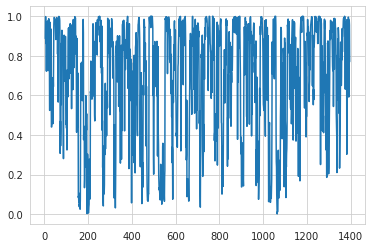

In [94]:
sns.lineplot(data=C2_K1_SW[0][0])

In [95]:
def p_value_mean(ps, mdiff):
    keys = range(len(ps))
    ps_equal_key = np.mean([ps[i][i] for i in keys], axis=0)
    ps_different_key = np.mean([ps[i][j] for i in keys for j in keys if i != j], axis=0)

    return ps_equal_key, ps_different_key

In [96]:
def pv_plot(chi2_results, mdiff):
    pv_mean = p_value_mean(chi2_results, mdiff)

    shadow_plot({
        "Average p-value for equal keys": pv_mean[0],
        "Average p-value for different keys": pv_mean[1]
    }, title="$p$-value for equal keys vs. $p$-value for different keys.\n")

    line_plot_poi({
        "$p$-value mean difference": np.array(pv_mean[0] - pv_mean[1]), # Equal keys - Different keys
        "Sample point mean difference": mdiff[1] # 1st order moment difference
    }, select_poi(mdiff[1], SLIDING_WINDOW_SIZE), poi_alpha=.1,
        title="$p$-value difference vs. sample point difference.\n"
              "Points of Interest are highlighted.\n", xlim=(0, 700))

    line_plot_poi({
        "$p$-value mean difference": np.array(pv_mean[0] - pv_mean[1]), # Equal keys - Different keys
        "Sample point mean difference": mdiff[1] # 1st order moment difference
    }, select_poi(mdiff[1], SLIDING_WINDOW_SIZE), poi_alpha=.1,
        title="$p$-value difference vs. sample point difference.\n"
              "Points of Interest are highlighted.\n", xlim=(30, 100))

# $\chi^2$-test $p$-value difference

If there is a leakage, traces with equal keys should show dependence and
traces that have different keys should show independence.

Small $p$ values give evidence to reject the null hypothesis and conclude that the observations are not independent.

Leakage can therefore be detected when $p$-values for equal keys are significantly lower than
$p$-values for different keys.

### $p$-value difference per sample point

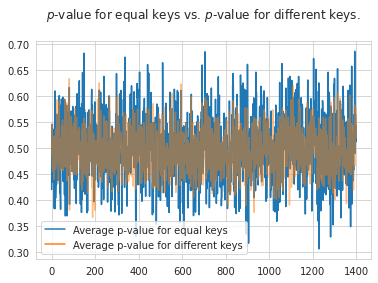

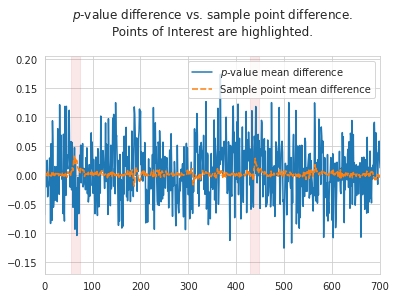

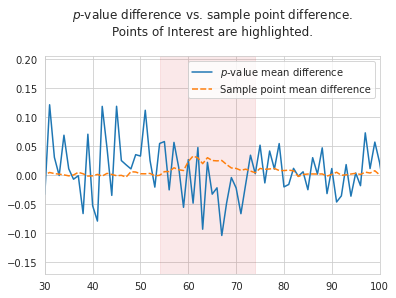

In [97]:
pv_plot(C2_K1_SP, cache_np("mdiff_prof", v=1))

In [98]:
cache_np("mdiff_prof", v=1)[1].shape

(1400,)

### $p$-value difference per sliding window

In [99]:
Markdown(f"Sliding window size: ({SLIDING_WINDOW_SIZE}), Sliding window step: (1).")

Sliding window size: (10), Sliding window step: (1).

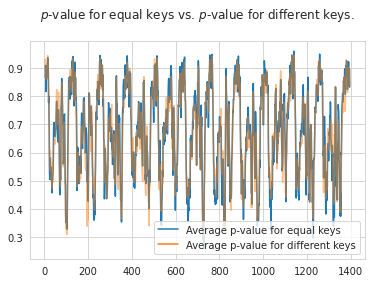

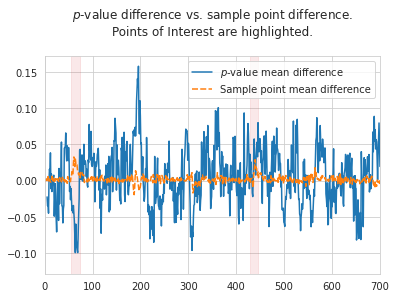

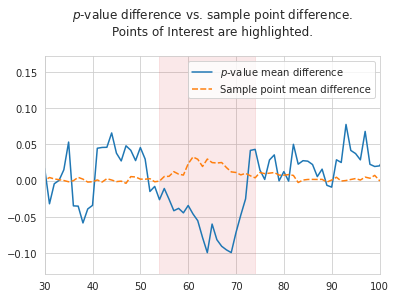

In [100]:
pv_plot(C2_K1_SW, cache_np("mdiff_prof", v=1))

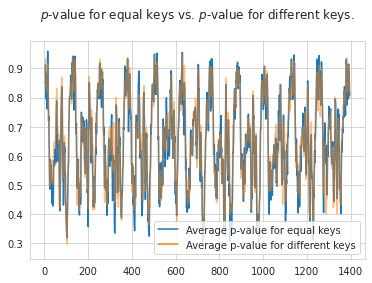

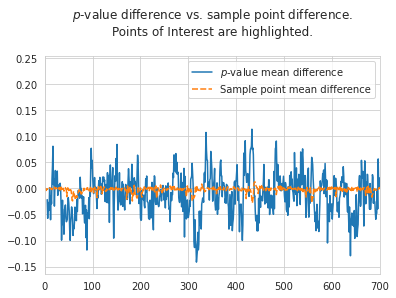

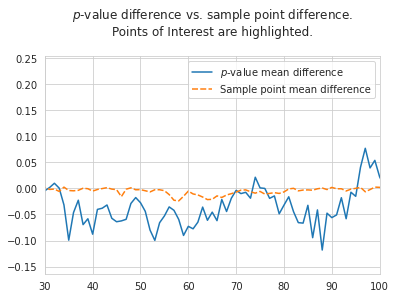

In [101]:
pv_plot(C2_K3_SW, cache_np("mdiff_mask", v=1))

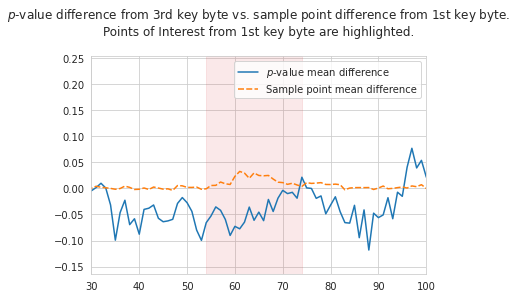

In [102]:
MDIFF = cache_np("mdiff_prof", v=1)
PVM = np.array(p_value_mean(C2_K3_SW, MDIFF))
line_plot_poi({
        "$p$-value mean difference": np.array(PVM[0] - PVM[1]), # Equal keys - Different keys
        "Sample point mean difference": MDIFF[1] # 1st order moment difference
    }, select_poi(MDIFF[1]), poi_alpha=.1,
        title="$p$-value difference from 3rd key byte vs. sample point difference from 1st key byte.\n"
              "Points of Interest from 1st key byte are highlighted.\n", xlim=(30, 100))

[Text(0.5, 1.0, 'Mean $p$-value in first PoI')]

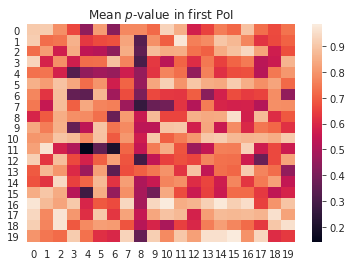

In [103]:
def avg_pv_poi(chi2_results, mdiff):
    pl, pr = select_poi(mdiff[1])[0]
    p_mean = np.moveaxis(chi2_results, -1, 0)[pl:pr].mean(axis=0)

    return p_mean

AVG_PVS = avg_pv_poi(C2_K1_SW, MDIFF)

sns.heatmap(AVG_PVS).set(title="Mean $p$-value in first PoI")

[Text(0.5, 1.0, 'Mean $p$-value in first PoI')]

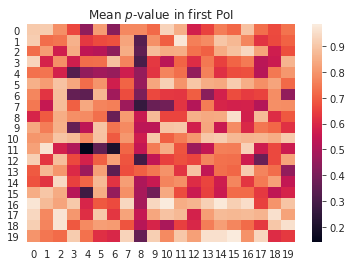

In [104]:
PVS_LIMIT = 20
sns.heatmap(AVG_PVS[:PVS_LIMIT, :PVS_LIMIT]).set(title="Mean $p$-value in first PoI")

In [105]:
def avg_pv_poi_diff(subject, chi2_results, mdiff):
    avg_pvs = avg_pv_poi(chi2_results, mdiff)
    num_keys = len(avg_pvs)

    avg_neq = (avg_pvs * (1 - np.identity(num_keys))).sum() / (num_keys ** 2 - num_keys)
    avg_eq = (avg_pvs * (np.identity(num_keys))).sum() / num_keys

    return Markdown(f"""{subject}: Average `p`-value for equal keys: `{avg_eq:.4f}`.
    Average `p`-value for different keys: `{avg_neq:.4f}`""")

In [106]:
avg_pv_poi_diff("Key 1, Sample point", C2_K1_SP, MDIFF)

Key 1, Sample point: Average `p`-value for equal keys: `0.4996`.
    Average `p`-value for different keys: `0.5113`

In [107]:
avg_pv_poi_diff("Key 1, Sliding window", C2_K1_SW, MDIFF)

Key 1, Sliding window: Average `p`-value for equal keys: `0.6653`.
    Average `p`-value for different keys: `0.7169`

In [108]:
avg_pv_poi_diff("Key 1, Sliding window", C2_K3_SW, MDIFF)

Key 1, Sliding window: Average `p`-value for equal keys: `0.6118`.
    Average `p`-value for different keys: `0.6563`

In [112]:
from numpy.random import seed
from numpy.random import randn
from scipy.stats import normaltest

# seed the random number generator
seed(1)
# generate univariate observations
data = 5 * randn(100) + 50

stat, p = normaltest(data)

In [ ]:
# normality test
stat, p = normaltest(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')